## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048863


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Weights are randomly initiliazed, therefore classifier should randomly guess the class. Randomly guessing a class means the probability of choosing that class is 1/10 where 10 is the number of classes. Since our loss function is negative log-probability, -log(1/10) = log(10) = 2.3.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.960939 analytic: -0.960939, relative error: 1.426816e-08
numerical: 2.595124 analytic: 2.595124, relative error: 8.445868e-09
numerical: -0.504541 analytic: -0.504541, relative error: 2.965655e-08
numerical: 2.796462 analytic: 2.796462, relative error: 2.667713e-09
numerical: -1.801980 analytic: -1.801981, relative error: 3.141575e-08
numerical: 1.388577 analytic: 1.388577, relative error: 2.193987e-08
numerical: -1.940394 analytic: -1.940394, relative error: 4.875162e-09
numerical: -1.064656 analytic: -1.064656, relative error: 2.460331e-08
numerical: 0.278238 analytic: 0.278238, relative error: 1.142827e-08
numerical: -1.554694 analytic: -1.554694, relative error: 4.056617e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3319379211333056 / 310.07680893055635 computed in 0.015015840530395508s
Vectorized loss / grad: 2.331937921133306 / 310.07680893055635 computed in 0.002000093460083008s
difference in loss / grad: -4.440892098500626e-16 /2.7866450218004654e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981614
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.8532611454359382
iteration 700 / 1500: loss 1.8353062223725827
iteration 800 / 1500: loss 1.829389246882764
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.97835035402523
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 4.577153205871582s


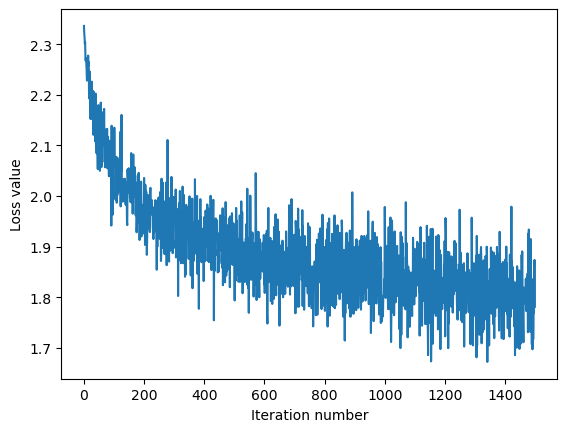

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [13]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = np.geomspace(1e-9, 1e-3, num= 7)
acc = []

for learning_rate in learning_rates:
    clf = Softmax()
    clf.train(X_train,y_train,learning_rate = learning_rate, num_iters = 1500, verbose = False)
    prediction = clf.predict(X_val)
    accuracy = np.sum(prediction == y_val) / y_val.shape[0]
    acc.append(accuracy)

best_idx = np.argmax(acc)
print("All accuracies : ", acc)
print("Best validation accuracy is ", acc[best_idx], " with learning rate = ", learning_rates[best_idx])
print("Best validation error is ", 1 - acc[best_idx], " with learning rate = ", learning_rates[best_idx])

clf = Softmax()
clf.train(X_train,y_train,learning_rate = learning_rates[best_idx], num_iters = 1500, verbose = False)
prediction = clf.predict(X_test)
error_test = np.sum(prediction != y_test) / y_test.shape[0]

print("Error rate on the test set is ", error_test, " with learning rate = ", learning_rates[best_idx])    
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


All accuracies :  [0.16, 0.304, 0.395, 0.407, 0.33, 0.262, 0.288]
Best validation accuracy is  0.407  with learning rate =  1e-06
Best validation error is  0.593  with learning rate =  1e-06
Error rate on the test set is  0.608  with learning rate =  1e-06
